In [3]:
"""
12.11.19
This is a plotting routine to create detailed source-receiver maps for publications, talks
"""

'\n12.11.19\nThis is a plotting routine to create detailed source-receiver maps for publications, talks\n'

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach
from obspy import read_inventory, read_events
from IPython.core.debugger import set_trace
from IPython import embed


from pyatoa.utils.calculate import normalize_a_to_b, myround
from pyatoa.visuals.map_tools import event_beachball, interpolate_and_contour
from pyatoa.plugins.new_zealand.map_plugins import plot_geonet_active_faults

mpl.rcParams['axes.linewidth'] = 2.

In [5]:
def place_scalebar(m, map_corners, **kwargs):
    """
    Put the scale bar in a corner at a reasonable distance from each edge

    Handy reminder for moving the scalebar around:
        latitude is up, down
        longitude is right, left

    :type m: Basemap
    :param m: basemap object
    :type map_corners: dict of floats
    :param map_corners: [lat_bot,lat_top,lon_left,lon_right]
    :type loc: str
    :param loc: location of scalebar, 'upper-right' or 'lower-right'
    """
    loc = kwargs.get("scalebar_location", "upper-right")
    fontsize = kwargs.get("scalebar_fontsize", 13)
    linewidth = kwargs.get("scalebar_linewidth", 2)

    mc = map_corners
    if loc == "upper-right":
        latscale = mc['lat_min'] + (mc['lat_max'] - mc['lat_min']) * 0.94
        lonscale = mc['lon_min'] + (mc['lon_max'] - mc['lon_min']) * 0.875
    if loc == "lower-right":
        latscale = mc['lat_min'] + (mc['lat_max'] - mc['lat_min']) * 0.04
        lonscale = mc['lon_min'] + (mc['lon_max'] - mc['lon_min']) * 0.9
    m.drawmapscale(lonscale, latscale, lonscale, latscale, 100,
                   yoffset=0.01 * (m.ymax-m.ymin), zorder=5000, 
                   linewidth=linewidth, fontsize=fontsize
                   )

In [6]:
def initiate_basemap(map_corners, scalebar=True, **kwargs):
    """
    set up the basemap object in the same way each time

    :type map_corners: dict of floats
    :param map_corners: {lat_min,lat_max,lon_min,lon_max}
    :type scalebar: bool
    :param scalebar: add a scalebar to the map
    :rtype m: Basemap
    :return m: basemap object
    """
    continent_color = kwargs.get("continent_color", "w")
    lake_color = kwargs.get("lake_color", "w")
    coastline_zorder = kwargs.get("coastline_zorder", 5)
    coastline_linewidth = kwargs.get("coastline_linewidth", 2.0)
    fill_color = kwargs.get("fill_color", "w")
    fontsize = kwargs.get("fontsize", 13)

    # Initiate map and draw in style
    m = Basemap(projection='stere', resolution='h', rsphere=6371200,
                area_thresh=1000,
                lat_0=(map_corners['lat_min'] + map_corners['lat_max'])/2,
                lon_0=(map_corners['lon_min'] + map_corners['lon_max'])/2,
                llcrnrlat=map_corners['lat_min'],
                urcrnrlat=map_corners['lat_max'],
                llcrnrlon=map_corners['lon_min'],
                urcrnrlon=map_corners['lon_max'],
                )
    m.drawcoastlines(linewidth=coastline_linewidth, zorder=coastline_zorder)
    m.fillcontinents(color=continent_color, lake_color=lake_color)
    m.drawmapboundary(fill_color=fill_color)
    m.drawparallels(np.arange(int(map_corners['lat_min']),
                              int(map_corners['lat_max']), 1),
                    labels=[1, 0, 0, 0], linewidth=0, fontsize=fontsize,
                    rotation=45)
    m.drawmeridians(np.arange(int(map_corners['lon_min']),
                              int(map_corners['lon_max'])+1, 1),
                    labels=[0, 0, 0, 1], linewidth=0, fontsize=fontsize,
                    rotation=45)

    if scalebar:
        place_scalebar(m, map_corners, **kwargs)

    return m

In [68]:
def get_stations(m, station_info, sta_ignore=[], net_ignore=[], **kwargs):
    """
    Get station info from a Specfem STATION file
    
    :type m: basemap
    :param m: map for converting coordinates
    :type station_info: np.array
    :param station_info: array from reading in the station file using numpy
    """
    x, y, names = [], [], []
    for station in station_info:
        sta, net, lat, lon = station
        if net in net_ignore:
            continue
        if sta in sta_ignore:
            continue
        xy = m(float(lon), float(lat))
        x.append(xy[0])
        y.append(xy[1])
        names.append(f"{net}.{sta}")

    return x, y, names


def plot_stations(x, y, names=None, annotate=False, **kwargs):
    """
    Plot station information on the map with allowable colors
    
    :type x: list
    :param x: x coordinates 
    :type y: list
    :param y: y coordinates
    :type colors: list
    :param colors: color to plot each station
    """
    markersize = kwargs.get("markersize", 100)
    color = kwargs.get("color", "w")
    fontsize = kwargs.get("fontsize", 10)
    zorder = kwargs.get("zorder", 100)
    edgecolor = kwargs.get("station_edgecolor", "k")
    marker = kwargs.get("station_marker", "v")
    
    if names:
        for i, name in enumerate(names):
            if "NZ" in name:
                color = "k"
            else:
                color = "w"
            m.scatter(x[i], y[i], marker=station_marker, s=markersize, 
                      edgecolors=station_edgecolor, # hatch="|||",
                      c=color, linestyle='-', linewidth=2., zorder=zorder)
            if annotate:                      
                # Plot station names over the markers
                plt.text(x[i] + 0.015 * (m.xmax - m.xmin), y[i] - 0.0075 * (m.ymax - m.ymin),
                         s=names, fontsize=fontsize, zorder=zorder + 1, fontweight='roman',
                         bbox=dict(facecolor='w', fill=True, edgecolor='w', alpha=0.5, boxstyle='round')
                         )

    else:
        m.scatter(x, y, marker='v', s=markersize, edgecolors='k', 
                  c=color, linestyle='-', linewidth=2., zorder=zorder)
        
        
def plot_stations_beacon(x, y, names=None, annotate=False, **kwargs):
    """
    Plot station information on the map with allowable colors
    
    :type x: list
    :param x: x coordinates 
    :type y: list
    :param y: y coordinates
    :type colors: list
    :param colors: color to plot each station
    """
    markersize = kwargs.get("markersize", 100)
    fontsize = kwargs.get("fontsize", 10)
    zorder = kwargs.get("zorder", 100)
    
    if names:
        for i, name in enumerate(names):
            if "NZ" in name:
                color = "mediumspringgreen"
                markersize = 100
            else:
                color = "gold"
                markersize = 300
            if "RD11" in name or "RD17" in name:
                continue
            m.scatter(x[i], y[i], marker='d', s=markersize, edgecolors='k', # hatch="|||",
                      c=color, linestyle='-', linewidth=2., zorder=zorder)
            if annotate:
                anno_name = None
                if "XX" in name:
                    if "RD20" in name:
                        anno_name = "11 & 20"
                    elif "RD21" in name:
                        anno_name = "17 & 21"
                    else:
                        anno_name = name[-2:]

                else:
                    for check in ["MRZ", "TSZ", "BFZ", "PXZ", "BKZ"]:
                        if check in name:
                            anno_name =  name.split('.')[1]                        
                # Plot station names over the markers
                plt.text(x[i] + 0.015 * (m.xmax - m.xmin), y[i] - 0.0075 * (m.ymax - m.ymin),
                         s=anno_name, fontsize=fontsize, zorder=zorder + 1, fontweight='roman',
#                          bbox=dict(facecolor='w', fill=True, edgecolor='w', alpha=0.5, boxstyle='round')
                         )

    else:
        m.scatter(x, y, marker='v', s=markersize, edgecolors='k', 
                  c="w", linestyle='-', linewidth=2., zorder=zorder)
    

In [8]:
def plot_cities(m, names=False, **kwargs):
    """
    Plot major population centers
    
    qwer
    
    :type m: basemap
    :param m: map to plot cities on
    :type names: bool
    :param names: annotate names on map
    """
    markersize = kwargs.get("markersize", 80)
    color = kwargs.get("color", "w")
    fontsize = kwargs.get("fontsize", 12)
    zorder = kwargs.get("zorder", 100)
    
    city = True
    location = False

    locations = [(-41.28664, 174.77557, "Wellington", city),
                  (-39.4928, 176.9120, "Napier", city),
                  (-42.416665, 173.6833306, "Kaikoura", city),
                  (-38.6857, 176.0702, "Taupo", city),
                  (-39.2968, 174.0634, "Mt. Taranaki", city),
                  (-37.8, 176., "Bay of Plenty", location),
                  (-39.3314, 177.5017, "Hawke Bay", location),
#                   (-38.6623, 178.0176, "Gisborne", city),
#                   (-40.0741, 174.8985, "Taranaki Bight", location),
#                   (-36.8485, 174.7633, "Auckland", city),
#                   (-41.6, 174.3121, "Cook Strait", location),
#                   (-41.1383, 174.0870, "Marlborough Sounds", location)
#               (-38., 173.5, "Australian Plate", location),
#               (-42., 177.0, "Pacific Plate", location)
             ]

    for loc in locations:
        xy = m(loc[1], loc[0])
        if loc[3]:
            m.scatter(xy[0], xy[1], marker='o', s=markersize, edgecolor='k', 
                      c=color, linewidth=2, zorder=zorder)
            plt.text(xy[0] + 0.01 * (m.xmax - m.xmin), xy[1] + 0.01 * (m.ymax - m.ymin),
                     s = loc[2], fontsize=fontsize, zorder=zorder, fontweight='normal',
                     bbox=dict(facecolor='w', fill=True, edgecolor='k', linewidth=1.5, alpha=.85, boxstyle="round")
                     )
        else:
            plt.text(xy[0] + 0.01 * (m.xmax - m.xmin), xy[1] + 0.01 * (m.ymax - m.ymin),
                     s = loc[2], fontsize=fontsize, zorder=zorder, fontweight='normal',
                     bbox=dict(facecolor='w', fill=True, edgecolor='k', linewidth=1.5, alpha=.85, boxstyle="square")
                     )


In [46]:
def get_beachballs(cat, cmap, norm_a=1.4E4, norm_b=2.3E4):
    """
    Get event information from the moment tensor attributes of the
    
    :type cat: obspy.Catalog
    :param cat: catalog with events that contain moment tensor attributes
    :type cmap: matplotlib.colors.ListedColorMap
    :param cmap: chosen colormap for event depths
    :rtype depths: list
    :return depths: depths in km from events
    :rtype mags: list
    :return mags: magnitudes of events
    :rtype normalize: matplotlib.colors.BoundaryNorm
    :retrun normalize: normalized discrete colormap for colorbar
    """
    depths, mags, depths = [], [], []
    for event in cat:
        try:
            depth = event.preferred_origin().depth * 1E-3
            if depth > 60:
                continue
            depths.append(depth)
            mags.append(event.preferred_magnitude().mag)
        except AttributeError:
            depths.append(event.origins[0].depth * 1E-3)
            mags.append(event.magnitudes[0].mag)
            
    # normalize the colormap, create a discrete colorbar
    max_depth = myround(max(depths), 5, 'up')
    normalize = mpl.colors.BoundaryNorm(range(0, max_depth, 5), cmap.N)

    # normalize the magnitudes
    mags = normalize_a_to_b(mags, a=norm_a, b=norm_b)

    return depths, mags, normalize
    
    
def plot_beachballs(m, cat, depths, mags, cmap, normalize, **kwargs):
    """
    Plot moment tensors as beachballs, color by depth if requested

    :type m: basemap
    :param m: map to plot beacbhalls on
    :type cat: obspy.Catalog
    :param cat: catalog with events
    :type depths: list
    :param depths: depths in km of events
    :type mags: list
    :param mags: magnitudes of events
    :type cmap: matplotlib.colors.ListedColorMap
    :param cmap: chosen colormap for event depths
    :type normalize: matplotlib.colors.BoundaryNorm
    :param normalize: normalized discrete colormap for colorbar
    """
    cbar_shrink = kwargs.get("cbar_shrink", 0.35)
    cbar_fontsize = kwargs.get("cbar_fontsize", 15)
    cbar_tickfontsize = kwargs.get("cbar_tickfontsize", 15)
    cbar_labelpad = kwargs.get("cbar_labelpad", 15)
    
    for i, event in enumerate(cat[:-1]):
        event_beachball(m, event, fm_type="strike_dip_rake",
                        facecolor=cmap(normalize(depths[i])),
                        width=mags[i],
                        **kwargs
                        )

    # create a colormap for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    cbar = plt.colorbar(sm, extend='max', shrink=cbar_shrink, aspect=10)
    cbar.set_label("depth (km)", rotation=270, labelpad=cbar_labelpad, fontsize=cbar_fontsize)
    cbar.ax.invert_yaxis()
    cbar.ax.tick_params(axis='y', direction='in', length=0, width=3., 
                        labelsize=cbar_tickfontsize)
    
    
def plot_beachball_depth(cat, norm_a, norm_b, choice):
    """
    Plot moment tensors by depth
    """
    f, ax = plt.subplots(1)
    
    mags, depths, x_values = [], [], []
    for i, event in enumerate(cat):
        depth = event.preferred_origin().depth * 1E-3
        if depth > 60:
            continue
        depths.append(depth)
        mags.append(event.magnitudes[0].mag)
        
        if choice == "x":
            x_values.append(event.preferred_origin().longitude)
        else:
            x_values.append(event.preferred_origin().latitude)

    mags = normalize_a_to_b(mags, a=norm_a, b=norm_b)

    plt.scatter(x_values, depths, c='None', edgecolor='k', s=mags)
        
    ax.invert_yaxis()
    ax.set_ylabel("depth (km)")
    if choice == "x":
        ax.set_xlabel("Longitude (deg)")
    else:
        ax.set_xlabel("Latitude (deg)")


In [10]:
def moment_tensor_to_moment_magnitude(moment_tensor):
    """
    Convet sesmic moment tensor to seismic moment magnitude
    """
    from numpy import sqrt
    moment = sum([_**2 for _ in moment_tensor])
    moment = sqrt(moment)
    moment /= sqrt(2)
    
    mw = 2/3 * np.log10(moment) - 10.7

    return mw
                  

def plot_beachballs_npz(m, npzcat, cmap, norm_a, norm_b, **kwargs):
    """
    Plot moment tensors as beachballs, color by depth if requested

    :type m: basemap
    :param m: map to plot beacbhalls on
    :type cat: obspy.Catalog
    :param cat: catalog with events
    :type depths: list
    :param depths: depths in km of events
    :type mags: list
    :param mags: magnitudes of events
    :type cmap: matplotlib.colors.ListedColorMap
    :param cmap: chosen colormap for event depths
    :type normalize: matplotlib.colors.BoundaryNorm
    :param normalize: normalized discrete colormap for colorbar
    """
    cbar_shrink = kwargs.get("cbar_shrink", 0.35)
    
    depths = npzcat["depth"]
    latitude = npzcat["latitude"]
    longitude = npzcat["longitude"]
    mrr = npzcat["Mrr"]
    mtt = npzcat["Mtt"]
    mpp = npzcat["Mpp"]
    mrt = npzcat["Mrt"]
    mrp = npzcat["Mrp"]
    mtp = npzcat["Mtp"]
            
    # normalize the colormap, create a discrete colorbar
    max_depth = myround(max(depths), 5, 'up')
    normalize = mpl.colors.BoundaryNorm(range(0, max_depth, 5), cmap.N)
    
    # get magnitude information
    mags = []
    for i in range(len(depths)):
        moment_tensor = [mrr[i], mtt[i], mpp[i], mrt[i], mrp[i], mtp[i]]
        mag = moment_tensor_to_moment_magnitude(moment_tensor)
        mags.append(mag)

    mags = normalize_a_to_b(mags, norm_a, norm_b)
    
    for i in range(len(depths)):
        x, y = m(longitude[i], latitude[i])
        moment_tensor = [mrr[i], mtt[i], mpp[i], mrt[i], mrp[i], mtp[i]]
        b = beach(moment_tensor, xy=(x, y), width=mags[i], facecolor=cmap(normalize(depths[i])))
        b.set_zorder(200)
        ax = plt.gca()
        ax.add_collection(b)

    # create a colormap for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    cbar = plt.colorbar(sm, extend='max', shrink=cbar_shrink, aspect=10)
    cbar.set_label("depth (km)", rotation=270, labelpad=15, fontsize=15)
    cbar.ax.invert_yaxis()
    cbar.ax.tick_params(axis='y', direction='in', length=0, width=1.75)
    

In [11]:
def interpolate_interface(m, plate):
    """
    Interpolate an interface for contour plot
    
    :type m: basemap
    :param m: map convert coordinates
    :type plate: np.array
    :param plate: info read in from plate interface npy file
    :rtype xi, yi, zi: np.array
    :return xi, yi, zi: gridded data for use in contour
    """
    lats = plate[:, 0]
    lons = plate[:, 1]
    depths = plate[:, 2]
    depths = [-1 * _ for _ in depths]
    
    x, y = m(lons, lats)
    xi = np.linspace(min(x), max(x), 1000)
    yi = np.linspace(min(y), max(y), 1000)
    
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), depths, (xi, yi))
    
    return xi, yi, zi


def plot_interface_contour(m, xi, yi, zi, **kwargs):
    """
    Plot the plate interface as contours, inline labels for depths
    
    :type m: basemap
    :param m: map convert coordinates
    :type plate: np.array
    :param plate: info read in from plate interface npy file
    :type xi, yi, zi: np.array
    :param xi, yi, zi: gridded data for use in contour
    """
    zorder = kwargs.get("zorder", 100)
    levels = kwargs.get("levels", [0,5,10,15,25,50,100,200,300])
    color = kwargs.get("color", "k")
    linestyle = kwargs.get("linestyle", "dotted")
    linewidth = kwargs.get("linewidth", 3)
    alpha = kwargs.get("alpha", 0.5)
    fontsize = kwargs.get("fontsize", 12)
    fontweight = kwargs.get("fontweight", "normal")
    format_ = kwargs.get("format", '%.0f km')

    cs = m.contour(xi, yi, zi, levels, vmin=0, colors=color, linestyles=linestyle, alpha=alpha, zorder=zorder, linewidth=linewidth)
    clabels = plt.clabel(cs, levels[1:], fontsize=fontsize, fmt=format_)#, fontweight=fontweight)
    [txt.set_bbox(dict(facecolor='white', edgecolor='None', pad=0)) for txt in clabels]


In [12]:
def draw_domain_bounds(m, bounds):
    """
    Draw the domain boundaries if theyre smaller than the map boundaries
    """
    lats = [bounds["lat_min"], bounds["lat_max"], bounds["lat_max"], bounds["lat_min"]]
    lons = [bounds["lon_min"], bounds["lon_min"], bounds["lon_max"], bounds["lon_max"]]
    x, y = m(lons, lats)
    xy = zip(x,y)
    poly = mpl.patches.Polygon(list(xy), facecolor='None', edgecolor="k", linewidth=1., linestyle='--', alpha=1)
    plt.gca().add_patch(poly)

In [13]:
# User Parameters
# Lat_min: 20 km south of KHZ (173.359, -42.416); Lat_max: 20 km north of KAZ (175.1612, -37.1http://localhost:8888/notebooks/srcrcv_map.ipynb#041)
# Lon_min: 20 km west of NNZ (173.3795, -41.2171); Lon_max: 20 km east of MXZ (179.3066, -37.5623)

map_corners={'lat_min': -42.65, 'lat_max': -36.75,  # map coordinates for moment tensors
             'lon_min': 172.55, 'lon_max': 178.65}

domain_bounds={'lat_min': -42.5, 'lat_max': -37.0,  # meshfem domain coordinates for moment tensors
               'lon_min': 173.0, 'lon_max': 178.5}

# map_corners={'lat_min': -42.6, 'lat_max': -36.925,  # tight map coordinates for ray paths
#              'lon_min': 173.14, 'lon_max': 178.5}

# map_corners={'lat_min': -41.75, 'lat_max': -38.75,  # for Beacon stations only
#              'lon_min': 174.5, 'lon_max': 177.8}


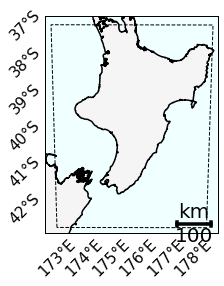

In [31]:
# Plotting kwargs that need to be instantiated before data collection
figsize = (10, 12)
dpi = 100
coastline_linewidth = 1.5
continent_color= "whitesmoke"
lake_color = "azure"
fill_color = "azure"
scalebar_location = "lower-right"
scalebar_fontsize = 20
scalebar_linewidth = 3.5
fontsize = 15

# initiate a basemap with the correct corners to use for coordinate transforms
m = initiate_basemap(map_corners, continent_color=continent_color,
                     lake_color=lake_color, fill_color=fill_color,
                     coastline_linewidth=coastline_linewidth, scalebar=True,
                     scalebar_location=scalebar_location, fontsize=fontsize,
                     scalebar_fontsize=scalebar_fontsize, 
                     scalebar_linewidth=scalebar_linewidth)
draw_domain_bounds(m, domain_bounds)

In [64]:
# STATION INFORMATION
net_ignore = ["X1", "X2", "GH"]
sta_ignore = ["MRWZ"]

if False:
    stations = np.loadtxt("./TRIAL_STATIONS_CHKBD", usecols=(0,1,2,3), dtype=str)  # in Specfem3D format
else:
    stations = np.loadtxt("./TRIAL_STATIONS_LARGE", usecols=(0,1,2,3), dtype=str)  # in Specfem3D format

sta_x, sta_y, sta_names = get_stations(m, stations, net_ignore=net_ignore, sta_ignore=sta_ignore)

# BEACHBALL MOMENT TENSOR INFORMATION
beachball_colormap = plt.cm.jet_r
if False:
    # This is for the synthetic inversions
    beachball_norms = [1.5E4, 3E4]
    cat = read_events("./charlie_trial_31.xml")  # Based on the events used in your inversion
    depths, mags, normalize = get_beachballs(cat, cmap=beachball_colormap, norm_a=beachball_norms[0],
                       norm_b=beachball_norms[1])
else:    
    # This is for all events
    beachball_norms = [1.25E4, 2.25E4]
    cat = read_events("fullscale_w_mt.xml")
    depths, mags, normalize = get_beachballs(cat, cmap=beachball_colormap, norm_a=beachball_norms[0],
                                             norm_b=beachball_norms[1])
    
# PLATE INTERFACE CONTOURS
if False:
    plate = np.load("./plate_interface.npy")  # Created from Charle's Williams plate interface model
    xi, yi, zi = interpolate_interface(m, plate)

In [69]:
# THIS CELL CREATES A GENERAL SOURCE RECEIVER WITH DOMAIN BOUNDARY AND ANNOTATED CITIES
if False:
    %matplotlib inline

    figsize = (10, 12)
    dpi = 100
    coastline_linewidth = 1.5
    continent_color= "whitesmoke"
    lake_color = "azure"
    fill_color = "azure"
    scalebar_location = "lower-right"
    scalebar_fontsize = 16.
    scalebar_linewidth = 2.5
    fontsize = 15
    
    # Plotting Kwargs to control element sizes and colors 
    station_markersize = 50
    station_zorder = 100
    station_color = "k"
    station_marker = "d"
    station_edgecolor = "k"

    beachball_linewidths = 1.6
    beachball_zorder = station_zorder - 2
    cbar_shrink = 0.2
    cbar_fontsize = 15
    cbar_tickfontsize = 15
    cbar_labelpad = 17.5

    city_zorder = station_zorder - 1
    city_markersize = 125
    city_fontsize = 14
    city_names = True
    city_color = "yellow"

    contour_zorder = station_zorder - 5
    contour_levels = [0,5,10,15,25,50,100,200,300]
    contour_color = "k"
    contour_linestyle = "dotted"
    contour_alpha = 1.
    contour_linewidth = 1.
    clabel_fontsize = 15
    clabel_fontweight = "heavy"
    clabel_format = '%.0f km'

    fault_linestyle = "-."
    fault_linewidth = 1
    fault_color = 'k'
    fault_zorder = station_zorder - 3
    fault_alpha = 0.25
    
    f = plt.figure(figsize=figsize, dpi=dpi)
    ax = f.add_subplot(111)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

    m = initiate_basemap(map_corners, continent_color=continent_color,
                         lake_color=lake_color, fill_color=fill_color,
                         coastline_linewidth=coastline_linewidth, scalebar=True,
                         scalebar_location=scalebar_location, fontsize=fontsize,
                         scalebar_fontsize=scalebar_fontsize, 
                         scalebar_linewidth=scalebar_linewidth
                         )

    draw_domain_bounds(m, domain_bounds)

    # Plot each of the individual components
    plot_stations(sta_x, sta_y, sta_names, annotate=False, net_ignore=net_ignore, 
                  markersize=station_markersize, zorder=station_zorder, color=station_color,
                  station_edgecolor=station_edgecolor, station_marker=station_marker)

    plot_beachballs(m, cat, depths, mags, beachball_colormap, normalize, linewidth=beachball_linewidths, zorder=beachball_zorder, 
                    cbar_shrink=cbar_shrink, cbar_fontsize=cbar_fontsize, cbar_tickfontsize=cbar_tickfontsize,
                    cbar_labelpad=cbar_labelpad)
    plot_cities(m, zorder=city_zorder, markersize=city_markersize, fontsize=city_fontsize, names=city_names,
                color=city_color)

    plot_interface_contour(m, xi, yi, zi, zorder=contour_zorder, levels=contour_levels, color=contour_color, 
                           linestyle=contour_linestyle, alpha=contour_alpha, 
                           fontsize=0, format_=clabel_format, linewidth=contour_linewidth)

    f.tight_layout()
    plt.savefig("./figures/srcrcv_map.png", dpi=dpi, figsize=figsize)

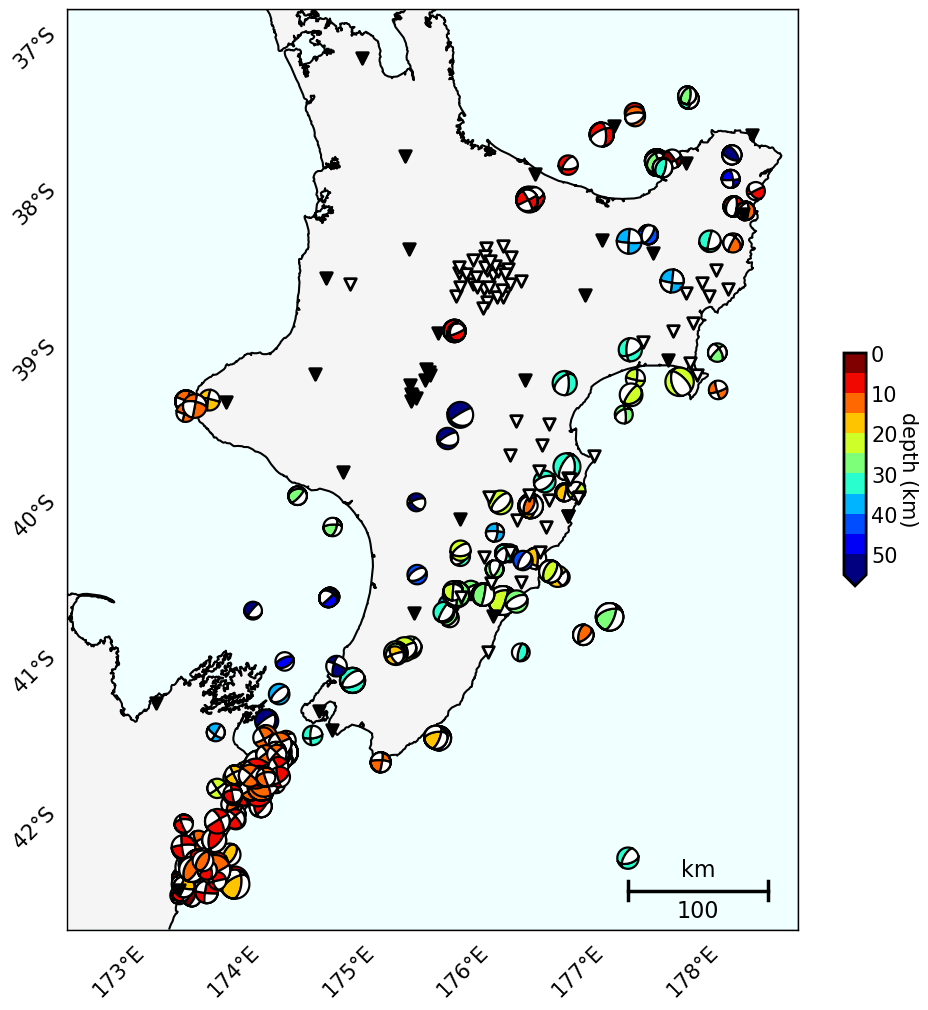

In [71]:
# THIS CELL CREATES A GENERAL SOURCE RECEIVER MAP WITH FULL EVENT CATALOG (all_events)
if True:
    %matplotlib inline

    figsize = (10, 12)
    dpi = 100
    coastline_linewidth = 1.5
    continent_color= "whitesmoke"
    lake_color = "azure"
    fill_color = "azure"
    scalebar_location = "lower-right"
    scalebar_fontsize = 16.
    scalebar_linewidth = 2.5
    fontsize = 15
    
    # Plotting Kwargs to control element sizes and colors 
    station_markersize = 70
    station_zorder = 100
    station_color = "k"
    station_marker = "v"
    station_edgecolor = "k"

    beachball_linewidths = 1.6
    beachball_zorder = station_zorder - 2
    cbar_shrink = 0.2
    cbar_fontsize = 15
    cbar_tickfontsize = 15
    cbar_labelpad = 17.5

    city_zorder = station_zorder - 1
    city_markersize = 125
    city_fontsize = 14
    city_names = True
    city_color = "yellow"

    contour_zorder = station_zorder - 5
    contour_levels = [0,5,10,15,25,50,100,200,300]
    contour_color = "k"
    contour_linestyle = "dotted"
    contour_alpha = 1.
    contour_linewidth = 1.
    clabel_fontsize = 15
    clabel_fontweight = "heavy"
    clabel_format = '%.0f km'

    fault_linestyle = "-."
    fault_linewidth = 1
    fault_color = 'k'
    fault_zorder = station_zorder - 3
    fault_alpha = 0.25
    
    f = plt.figure(figsize=figsize, dpi=dpi)
    ax = f.add_subplot(111)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

    m = initiate_basemap(map_corners, continent_color=continent_color,
                         lake_color=lake_color, fill_color=fill_color,
                         coastline_linewidth=coastline_linewidth, scalebar=True,
                         scalebar_location=scalebar_location, fontsize=fontsize,
                         scalebar_fontsize=scalebar_fontsize, 
                         scalebar_linewidth=scalebar_linewidth
                         )

    # Plot each of the individual components
    plot_stations(sta_x, sta_y, sta_names, annotate=False, net_ignore=net_ignore, 
                  markersize=station_markersize, zorder=station_zorder, color=station_color,
                  station_edgecolor=station_edgecolor, station_marker=station_marker)

    plot_beachballs(m, cat, depths, mags, beachball_colormap, normalize, linewidth=beachball_linewidths, 
                    zorder=beachball_zorder, cbar_shrink=cbar_shrink)
    f.tight_layout()
    
    plt.savefig("./figures/all_events.png", dpi=dpi, figsize=figsize)

In [18]:
# THIS CELL CREATES A SOURCE RECEIVER MAP USED TO MIMIC TAPE ET AL 2010 SRCRCV MAP
if False:
        # Plotting Kwargs to control element sizes and colors 
    station_markersize = 200
    station_zorder = 100
    station_color = "ivory"
    station_marker = 11
    station_edgecolor = "k"

    beachball_linewidths = 1.6
    beachball_zorder = station_zorder - 1
    cbar_shrink = 0.2

    city_zorder = station_zorder + 1
    city_markersize = 125
    city_fontsize = 14
    city_names = True
    city_color = "yellow"

    contour_zorder = station_zorder - 2
    contour_levels = [0,5,10,50,200,300]
    contour_color = "k"
    contour_linestyle = "dotted"
    contour_alpha = 1.
    contour_linewidth = 1.
    clabel_fontsize = 15
    clabel_fontweight = "heavy"
    clabel_format = '%.0f km'

    fault_linestyle = "-."
    fault_linewidth = 1
    fault_color = 'k'
    fault_zorder = station_zorder - 3
    fault_alpha = 0.25
    
    f = plt.figure(figsize=figsize, dpi=dpi)
    ax = f.add_subplot(111)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

    m = initiate_basemap(map_corners, continent_color=continent_color,
                         lake_color=lake_color, fill_color=fill_color,
                         coastline_linewidth=coastline_linewidth, scalebar=True,
                         scalebar_location=scalebar_location
                         )


    # plot beachballs
    for i, event in enumerate(cat):
        try:
            depth = event.preferred_origin().depth * 1E-3
        except AttributeError:
            depth = event.origins[0].depth * 1E-3

        if 0 <= depth < 5:
            color = "red"
        elif 5 <= depth < 10:
            color = "gold"
        elif 10 <= depth < 15:
            color = "yellowgreen"
        elif 15 <= depth < 25:
            color = "royalblue"
        elif 25 <= depth < 35:
            color = "deepskyblue"
        elif 35 <= depth < 40:
            color = "blueviolet"
        else:
            color = "fuchsia"
        try:
            event_beachball(m, event, fm_type="strike_dip_rake", facecolor=color,
                            width=mags[i], zorder=100+1/mags[i], linewidth=beachball_linewidths)
        except AttributeError:
            continue

    # Make a legend with figure sizes, this breaks the catalog for some reason
    event_legend = cat[0].copy()
    event_legend.preferred_origin().latitude = -37.25
    event_legend.preferred_origin().longitude = 173.5
    event_beachball(m, event_legend, fm_type="strike_dip_rake", facecolor="k",
                    width=mags.min(), zorder=100, linewidth=beachball_linewidths)


    event_legend.origins[0].latitude = -37.5
    event_legend.origins[0].longitude = 173.5
    event_beachball(m, event_legend, fm_type="strike_dip_rake", facecolor="k",
                    width=mags.max(), zorder=100, linewidth=beachball_linewidths)



    # plot_cities(m, zorder=city_zorder, markersize=city_markersize, fontsize=city_fontsize, names=city_names,
    #             color=city_color)

    plot_interface_contour(m, xi, yi, zi, zorder=contour_zorder, levels=contour_levels, color=contour_color, 
                           linestyle=contour_linestyle, alpha=contour_alpha, 
                           fontsize=clabel_fontsize, format_=clabel_format)

    plot_geonet_active_faults(m, linestyle=fault_linestyle, linewidth=fault_linewidth, color=fault_color, 
                              alpha=fault_alpha)  # this takes a while

    plt.savefig("./figures/depth_map.png", dpi=dpi, figsize=figsize)

In [19]:
# THIS CELL CREATES A MISFIT MAP CONNECTING INDIVIDUAL STATIONS AND RECEIVERS
if False:
    figsize = (20, 24)
    dpi = 100
    f = plt.figure(figsize=figsize, dpi=dpi)
    ax = f.add_subplot(111)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

        # Plotting Kwargs to control element sizes and colors 
    station_markersize = 200
    station_zorder = 100
    station_color = "ivory"

    beachball_linewidths = 2.
    beachball_zorder = station_zorder - 1
    cbar_shrink = 0.2

    city_zorder = station_zorder + 1
    city_markersize = 125
    city_fontsize = 14
    city_names = True
    city_color = "yellow"

    contour_zorder = station_zorder - 2
    contour_levels = [0,5,10,50,200,300]
    contour_color = "k"
    contour_linestyle = "dotted"
    contour_alpha = 1.
    contour_linewidth = 1.
    clabel_fontsize = 15
    clabel_fontweight = "heavy"
    clabel_format = '%.0f km'

    fault_linestyle = "-."
    fault_linewidth = 1
    fault_color = 'k'
    fault_zorder = station_zorder - 3
    fault_alpha = 0.25

    
    m = initiate_basemap(map_corners, continent_color='w',
                         lake_color='w', fill_color='w',
                         coastline_linewidth=5, scalebar=True,
                         scalebar_location="lower-right", 
                         scalebar_fontsize=25,
                         scalebar_linewidth=5,
                         fontsize=30
                         )

    # Plot each of the individual components
    misfit_list = {"2014p952799": ("PXZ", "deepskyblue"), 
                   "2016p356297": ("WIZ", "gold"),
#                    "2019p738432": ("RATZ", "gold"),
                   # "2016p355601": ("BFZ", "gold"),
                   "2018p130600": ("TOZ", "crimson"),
                   "2017p012082": ("KHEZ", "lightgreen")
                   }

    # Get the event and receiver locations 
    for i, event in enumerate(cat):
        event_id = event.resource_id.id.split('/')[-1]
        if event_id in misfit_list:        
            event_beachball(m, event, fm_type="strike_dip_rake", linewidth=5,
                            facecolor=misfit_list[event_id][1], width=2.8E4, 
                            zorder=500
                            )
            ev_x, ev_y = m(event.preferred_origin().longitude, event.preferred_origin().latitude)
            for sta in stations:
                if sta[0] == misfit_list[event_id][0]:
                    sta_x, sta_y = m(sta[3], sta[2])
                    m.scatter(sta_x, sta_y, marker='d', s=1000, edgecolors='k', 
                              c=misfit_list[event_id][1], linestyle='-', linewidth=4.,
                              zorder=500)
                    break

            m.plot([ev_x, sta_x], [ev_y, sta_y], linestyle='-', linewidth=7, c=misfit_list[event_id][1], zorder=300)

    plt.savefig("./figures/misfit_map.png", dpi=dpi, figsize=figsize)

In [20]:
# THIS CELL PLOTS EVENTS BY DEPTH
if False:
    plot_beachball_depth(cat=cat, choice="x", norm_a=30, norm_b=100)
    plt.savefig("./figures/event_depths.png")